# Usage of the codes 

This notebook uses a dataset to present the main function from the class `BivariateBeta` from the `parameter_estimation.py` file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path, install_cmdstan

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import arviz as az
plt.style.use('science')

import sys
import os
sys.path.append('../scripts/python')

from parameter_estimation import BivariateBeta

Some pre sets:

In [58]:
folder = '../data/covid_tests_data/'
filter_func = lambda i: lambda x: float(re.findall('[0-9].[0-9][0-9]', x.replace(',', '.'))[i])

set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v3.stan')
model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

17:20:45 - cmdstanpy - INFO - compiling stan file /home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan to exe file /home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3
17:21:03 - cmdstanpy - INFO - compiled model executable: /home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3


## The data: Accuracy of diagnostic tests registered by ANVISA for COVID-19

A documentary investigation was carried out utilizing the information provided by manufacturers during their registration with Anvisa. 
The diagnostic tests recorded with Anvisa up to June 23, 2020, during the data collection period, were scrutinized through the use of the following link: [https://consultas.anvisa.gov.br/#/saude/q/?nomeTecnico=coronav%C3%ADrus](https://consultas.anvisa.gov.br/#/saude/q/?nomeTecnico=coronav%C3%ADrus).

The data that was registered with Anvisa during the time of registration was retrieved from the Agency's website, specifically from the General Management of Health Product Technology (GGTPS) for in vitro diagnosis. 
To present the data in a structured format, a standard table created by the authors was employed, gathering essential information such as: i) company/importer; ii) manufacturer/country; iii) sample; iv) whether it was classified as a quick test v) Anvisa registration number; vi) sensitivity/specificity data presented by the manufacturer. 
The information provided by the manufacturers during their registration with Anvisa was then used to generate graphs displaying the sensitivity and specificity of the diagnostic tests.

The data provided by the manufacturers were plotted in the figures presented to illustrate the IgG and/or IgM sensitivity and specificity of the tests:

a) immunochromatographic with blood sample (whole blood, venous whole blood, whole blood via digital puncture or dried blood), human serum or plasma;

b) immunochromatographic with secretion nasopharyngeal swab and oropharyngeal swab;

c) immunoassay with blood sample (whole blood, venous whole blood, whole blood via finger prick or dried blood), human serum or plasma;

d) immunoassay with nasopharyngeal swab and oropharyngeal swab secretion sample;

e) qualitative or semi-qualitative detection with blood sample

In [3]:
tables = [pd.read_csv(folder+'raw/table_a.csv'),
          pd.read_csv(folder+'raw/table_b.csv'),
          pd.read_csv(folder+'raw/table_c.csv'),
          pd.read_csv(folder+'raw/table_d.csv'),
          pd.read_csv(folder+'raw/table_e.csv'),
          pd.read_csv(folder+'raw/table_pcr_a.csv'),
          pd.read_csv(folder+'raw/table_pcr_b.csv'),
          pd.read_csv(folder+'raw/table_pcr_c.csv'),
         ]

letters = ['a', 'b', 'c', 'd', 'e', 'a_pcr', 'b_pcr', 'c_pcr']
for i in range(8):

    tables[i]['sensitivity']          = tables[i]['Sensitivity [95% CI]'].apply(filter_func(0))
    tables[i]['sensitivity_ci_lower'] = tables[i]['Sensitivity [95% CI]'].apply(filter_func(1))
    tables[i]['sensitivity_ci_upper'] = tables[i]['Sensitivity [95% CI]'].apply(filter_func(2))
    tables[i]['specificity']          = tables[i]['Specificity [95% CI]'].apply(filter_func(0))
    tables[i]['specificity_ci_lower'] = tables[i]['Specificity [95% CI]'].apply(filter_func(1))
    tables[i]['specificity_ci_upper'] = tables[i]['Specificity [95% CI]'].apply(filter_func(2))
    tables[i]['type']                 = letters[i]
    
    del tables[i]['Sensitivity [95% CI]']
    del tables[i]['Specificity [95% CI]']
    
df = pd.concat(tables)

In [4]:
df

,Study,TP,FP,FN,TN,sensitivity,sensitivity_ci_lower,sensitivity_ci_upper,specificity,specificity_ci_lower,specificity_ci_upper,type
0,10071770900,312,1,49,234,0.86,0.82,0.90,1.00,0.98,1.00,a
1,10071770901,46,3,2,47,0.96,0.86,0.99,0.94,0.83,0.99,a
2,10210410105,90,3,3,124,0.97,0.91,0.99,0.98,0.93,1.00,a
3,10310030208,171,12,12,514,0.93,0.89,0.97,0.98,0.96,0.99,a
4,10342880015,23,2,1,49,0.96,0.79,1.00,0.96,0.87,1.00,a
...,...,...,...,...,...,...,...,...,...,...,...,...
11,80867150018,209,10,0,370,1.00,0.98,1.00,0.97,0.95,0.99,a_pcr
12,80954880134,3,0,0,98,1.00,0.29,1.00,1.00,0.96,1.00,a_pcr
0,10009010357,60,0,0,60,1.00,0.94,1.00,1.00,0.94,1.00,b_pcr
1,10223400001,10,0,0,14,1.00,0.69,1.00,1.00,0.77,1.00,b_pcr


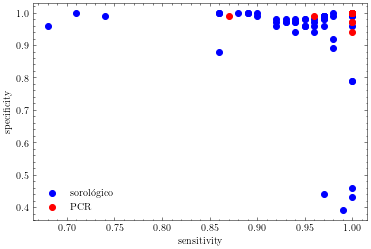

In [5]:
plt.scatter(df[~df.type.str.contains('pcr')].sensitivity, df[~df.type.str.contains('pcr')].specificity,
            color='blue', label='sorológico')
plt.scatter(df[df.type.str.contains('pcr')].sensitivity, df[df.type.str.contains('pcr')].specificity, 
            color='red', label='PCR')
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.legend(loc='lower left')
plt.show()

In [6]:
df.describe()

,Study,TP,FP,FN,TN,sensitivity,sensitivity_ci_lower,sensitivity_ci_upper,specificity,specificity_ci_lower,specificity_ci_upper
count,7.100000e+01,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,5.591396e+10,115.394366,13.971831,7.183099,191.676056,0.946901,0.835070,0.976479,0.942958,0.881127,0.962676
std,3.390722e+10,97.261427,45.681810,11.856656,212.390192,0.065500,0.174076,0.037037,0.132432,0.154064,0.113187
min,1.000901e+10,2.000000,0.000000,0.000000,5.000000,0.680000,0.160000,0.820000,0.390000,0.320000,0.440000
25%,1.034136e+10,49.000000,0.500000,0.000000,60.000000,0.930000,0.820000,0.970000,0.960000,0.890000,0.990000
50%,8.025802e+10,92.000000,2.000000,3.000000,124.000000,0.970000,0.890000,0.990000,0.980000,0.930000,1.000000
75%,8.086715e+10,169.000000,9.000000,7.500000,241.000000,1.000000,0.925000,1.000000,1.000000,0.960000,1.000000
max,8.198451e+10,422.000000,297.000000,49.000000,1364.000000,1.000000,0.980000,1.000000,1.000000,0.990000,1.000000


In [23]:
distribution = BivariateBeta()

x = df.specificity.values
y = df.sensitivity.values

m1 = np.mean(x)
m2 = np.mean(y)
v1 = np.var(x, ddof=1)
v2 = np.var(y, ddof=1)
rho = np.corrcoef(x, y)[0,1]

moments = [m1, m2, v1, v2, rho]
moments

[0.9429577464788733,
 0.9469014084507043,
 0.017538269617706236,
 0.0042902615694164975,
 -0.18700410861015324]

Estimating through the method of moments:

In [24]:
alpha_hat1 = distribution.method_moments_estimator_1(x, y)

In [25]:
alpha_hat2 = distribution.method_moments_estimator_2(x, y)

In [26]:
alpha_hat3 = distribution.method_moments_estimator_3(x, y, alpha0=(1,1))

In [27]:
alpha_hat4 = distribution.method_moments_estimator_4(x, y, alpha0=(1,1,1,1))

Using bootstrap

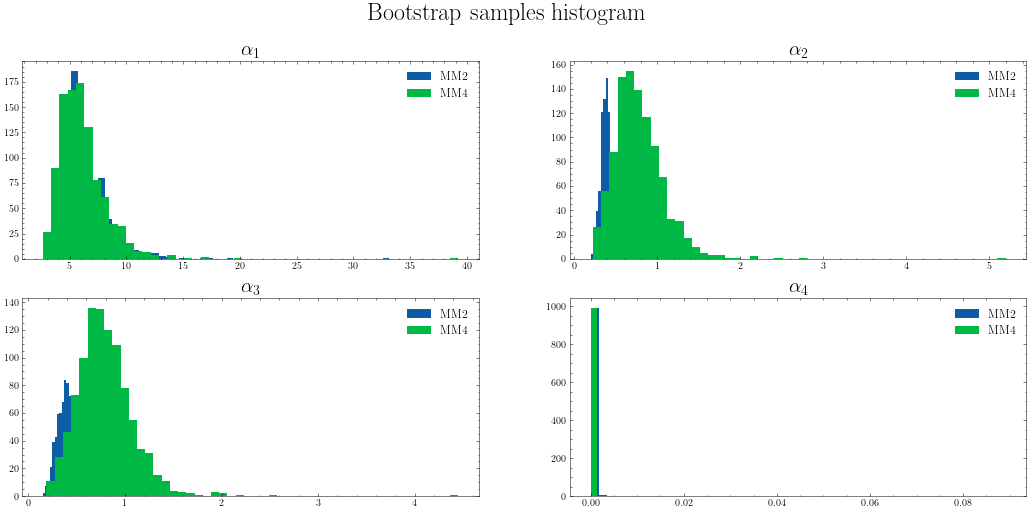

In [41]:
bootstrap_samples_2 = distribution.bootstrap_method(x, y, B=1000, method=distribution.method_moments_estimator_2)
bootstrap_samples_4 = distribution.bootstrap_method(x, y, B=1000, method=distribution.method_moments_estimator_4,
                                                    alpha0=(1,1,1,1))

fig, ax = plt.subplots(2,2,figsize=(18,8))
fig.suptitle('Bootstrap samples histogram', fontsize=24)
for k in range(4):
    i = k // 2
    j = k % 2
    ax[i,j].hist(bootstrap_samples_2[k,:], bins=50, label='MM2')
    ax[i,j].hist(bootstrap_samples_4[k,:], bins=50, label='MM4')
    ax[i,j].set_title(r'$\alpha_{}$'.format(k+1), fontsize=20)
    ax[i,j].legend(fontsize=12)
plt.show()

Frequentist diagnostics

In [43]:
distribution.marginal_diagnostic(x,y)

(-2.180356884666157, 0.0292310174720331)

Since $p$-value $< 0.05$, it indicates strong evidence against the null hypothesis that the data comes from the bivariate beta distribution and the marginal distributions do not obey the necessary relation.

In [45]:
distribution.positive_diagnostic_diagnostic(x,y)

-0.006696133857051478

For the positive test, we cannot reject the null hypotheses. 

From that analysis, we can see some difficulties in modelling this data using the Bivariate Beta model. Since we have observed values equal to $1$, the bayesian estimator will not work.

In [56]:
x[x==1] -= abs(np.random.normal(scale=1e-4, size=sum(x==1)))
y[y==1] -= abs(np.random.normal(scale=1e-4, size=sum(y==1)))

In [59]:
a = 1*np.ones(4)
b = 1*np.ones(4)

data = {'n': len(x), 'a': a, 'b': b, 'xy': np.column_stack([x,y])}

model_fit = model.sample(data=data, iter_warmup=2000, iter_sampling=2000, chains=4, adapt_delta=0.9)

17:21:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:22:19 - cmdstanpy - INFO - CmdStan done processing.
17:22:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[2] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
	Exception: gamma_lpdf: Random variable[2] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
	Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
	Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
	Exception: gamma_lpdf: Random varia

In [61]:
model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,614.686000,1.092520e+00,8.401190,599.782000,615.329000,628.087000,59.1326,0.408307,1.03056
alpha[1],3.728030,6.015700e-02,0.638302,2.698390,3.714600,4.824540,112.5850,0.777391,1.01910
alpha[2],0.198654,3.919680e-03,0.028502,0.156112,0.196553,0.250390,52.8745,0.365095,1.14318
alpha[3],0.133734,2.967030e-03,0.021815,0.101295,0.132441,0.172951,54.0579,0.373266,1.03834
alpha[4],0.122716,3.271690e-03,0.020658,0.089669,0.121496,0.158106,39.8705,0.275303,1.06531
...,...,...,...,...,...,...,...,...,...
u[67],0.969983,9.658670e-07,0.000012,0.969971,0.969976,0.970000,167.0540,1.153500,1.01744
u[68],0.999927,2.516340e-06,0.000014,0.999909,0.999936,0.999941,32.7669,0.226253,1.16055
u[69],0.999830,4.399310e-06,0.000037,0.999778,0.999854,0.999863,71.6326,0.494618,1.03793
u[70],0.999880,9.734250e-07,0.000015,0.999860,0.999888,0.999894,232.7600,1.607190,1.01689
